# CS155 Project 3 - Shakespearean Sonnets: Pre-processing data

**Author:** Liting Xiao

**Description:** this notebook pre-processes the Shakespeare's sonnet datasets for training.

In [1]:
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

### 0. Visualize Datasets

Let's visualize the two datasets using wordclouds.

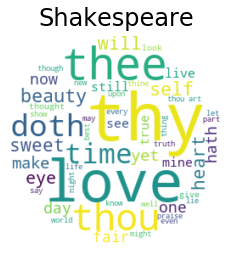

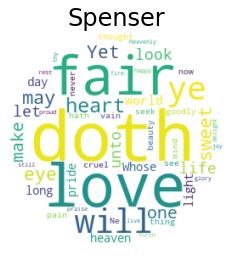

In [2]:
from HMM_helper import text_to_wordcloud

text = open('raw_data/shakespeare.txt').read()
wordcloud = text_to_wordcloud(text, title='Shakespeare')

text = open('raw_data/spenser.txt').read()
wordcloud = text_to_wordcloud(text, title='Spenser')

### 1. Basic Pre-processing (word-based) for HMM

My basic text pre-processing procedure includes:
- Make texts all lower case
- Remove punctuations
- Remove numbers irrelevant to poems
- Remove structural characters (newline char \n, space, etc)
- Tokenize texts

In [3]:
# don't count ' to keep apostrophes in words
# don't count - to keep hyphenated-words
punctuations = '''!()[]{};:"\,<>./?@#$%^&*_~'''

def hmm_preprocess(infiles):
    processed_seqs = []
    
    for infile in infiles:
        with open(infile) as f:
            # split the file into sequences, 1 line as a sequence
            for seq in f.readlines():
                # tokenize each seq
                words = seq.lower().split()

                # remove numerical numbers, roman numbers, and non-sensible lines
                if len(words) == 1:
                    continue
                
                # remove punctuations
                words = [re.sub('[%s]' % re.escape(punctuations), '', w) for w in words]

                # remove empty strings
                words = list(filter(None, words))

                # remove empty lists
                if words:
                    processed_seqs.append(words)

    print('Total number of sequences: {}'.format(len(processed_seqs)))
    
    return processed_seqs

For the naive HMM implementation, it uses ONLY Shakespeare's sonnet file:

In [4]:
basic_processed_seqs = hmm_preprocess(['raw_data/shakespeare.txt'])

Total number of sequences: 2155


For the advanced HMM implementation, it ALSO uses Spenser's sonnet file:

In [5]:
adv_processed_seqs = hmm_preprocess(['raw_data/shakespeare.txt', 'raw_data/spenser.txt'])
# for training the inverse lines
adv_processed_seqs_inv = [line[::-1] for line in adv_processed_seqs]

Total number of sequences: 3401


Now convert words to machine-readable vectors and save the data to files.

In [6]:
for processed_seqs, tag in zip([basic_processed_seqs, adv_processed_seqs, adv_processed_seqs_inv],
                               ['basic', 'adv', 'adv_inv']):
    # use set() to get unique words to form a vocabulary
    poem_vocab = sorted(set([item for sublist in processed_seqs for item in sublist]))

    # mappings of word2vec and vec2word
    word2vec = {unique: idx for idx, unique in enumerate(poem_vocab)}
    vec2word = {idx: unique for idx, unique in enumerate(poem_vocab)}

    # obtain sequence vectors
    processed_seqs_vec = []
    for seq in processed_seqs:
        words_vec = []
        for word in seq:
            words_vec.append(word2vec[word])
        processed_seqs_vec.append(words_vec)
        
    pickle.dump(processed_seqs_vec, open("processed_data/{}_processed_seqs_vec.p".format(tag), "wb"))

    if tag is not 'adv_inv':
        pickle.dump(word2vec, open("processed_data/{}_word2vec.p".format(tag), "wb"))

        pickle.dump(vec2word, open("processed_data/{}_vec2word.p".format(tag), "wb"))

        print('Total number of unique words for {} HMM pre-processing: {}'.format(tag, len(poem_vocab)))

Total number of unique words for basic HMM pre-processing: 3231
Total number of unique words for adv HMM pre-processing: 4391


Store the 'number of words per line' probabilities for poetry generation.

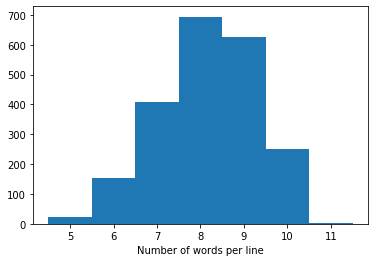

In [7]:
line_len = [len(l) for l in basic_processed_seqs]
lengths, bins, _ = plt.hist(line_len, bins=[i-0.5 for i in range(min(line_len), max(line_len)+2)])
plt.xlabel('Number of words per line')
pickle.dump(lengths / sum(lengths), open("processed_data/wordperline_prob.p", "wb"))

### 2. Adv Pre-processing specifically for Adv HMM

A few more text pre-processing (HMM): 
- Syllable count
- Rhyme

#### 2.1. `Syllable Count`

Syllable counts for *shakespeare.txt* are stored in file already.

In [8]:
word2syllable = {}
with open('raw_data/Syllable_dictionary.txt', 'r') as f:
    for line in f:
        line = line.rstrip('\n').split(' ')
        
        # split the line into words and syllables
        word = line[0]
        syls = line[1:]

        # loop through all possible syllable counts for a word
        for i, s in enumerate(syls):
            # append to word2syllable
            if i == 0:
                word2syllable[word] = [s]
            else:
                word2syllable[word].append(s)

We can also get syllable counts for *spenser.txt*.

In [9]:
import pronouncing as pro

word_syl = {}
# loop through the words in spenser.txt
for line in adv_processed_seqs[len(basic_processed_seqs):]:
    for word in line:
        # get pronounciation list of the word
        p_list = pro.phones_for_word(word)

        # if could find syllable info and not already stored
        if p_list and word not in word2syllable:
            word_syl = []
            for p in p_list:
                word_syl.append(pro.syllable_count(p))

            # get the unique syllable counts
            word_syl = sorted(list(set(word_syl)))
            
            # store into the big dictionary
            if len(word_syl) == 1:
                word2syllable[word] = [str(word_syl[0])]
            else:
                word2syllable[word] = ['E'+str(word_syl[0])]
                word2syllable[word].append(str(word_syl[1]))
                
# clean the special ending case
for w in word2syllable:
    if len(word2syllable[w]) > 1:
        if word2syllable[w][1][0] == 'E':
            word2syllable[w] = word2syllable[w][::-1]

# save the dictionary
pickle.dump(word2syllable, open("processed_data/word2syllable.p", "wb"))

#### 2.2. Rhyme

Create a rhyme dictionary.

In [10]:
rhymes = {}
for word in word2syllable:
    # get the rhymes corresponding to each word in the poem vocab
    word_rhymes = pro.rhymes(word)
    word_rhymes = [r for r in word_rhymes if r in word2syllable]
    
    # store non-empty lists into the rhymes dict
    if word_rhymes:
        rhymes[word] = word_rhymes

pickle.dump(rhymes, open("processed_data/rhymes.p", "wb"))

### 3. Basic Pre-processing (char-based) for Naive RNN

For the naive RNN implementation, let's use char-based sequences.

Clean the chars.

In [11]:
with open('raw_data/shakespeare.txt') as f:
    words = f.read().lower().split()
    
    # remove numbers
    words = [re.sub(r'\d+', '', w) for w in words]

    # remove punctuation except for ' and -
    words = [re.sub('[%s]' % re.escape(punctuations), '', w) for w in words]

    # remove empty strings
    words = list(filter(None, words))
    
    # get our final long list of chars
    raw_text = ' '.join(words)

Store all of the 40-char sequences.

In [12]:
max_len = 40
step = 1
basic_char_seqs = []
for i in range(0, len(raw_text)-max_len, step):
    basic_char_seqs.append(raw_text[i:i+max_len+1])
print('Total number of sequences: {}'.format(len(basic_char_seqs)))

Total number of sequences: 90965


Save the 'chars to vectors' and 'vectors to chars' mappings.

In [13]:
basic_chars = sorted(list(set(raw_text)))
basic_char2vec = dict((c, i) for i, c in enumerate(basic_chars))
basic_vec2char = dict((i, c) for i, c in enumerate(basic_chars))
pickle.dump(basic_char2vec, open("processed_data/basic_char2vec.p", "wb"))
pickle.dump(basic_vec2char, open("processed_data/basic_vec2char.p", "wb"))
print('Total number of unique chars: {}'.format(len(basic_char2vec)))
print('All unique chars: ')
print(basic_chars)

Total number of unique chars: 29
All unique chars: 
[' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Save the processed char-based sequence vectors.

In [14]:
basic_char_seqs_vec = []
for char_s in basic_char_seqs:
    basic_char_seqs_vec.append([basic_char2vec[c] for c in char_s])
pickle.dump(basic_char_seqs_vec, open("processed_data/basic_char_seqs_vec.p", "wb"))

Let's also see the distribution of number of chars per line in *shakespeare.txt*.

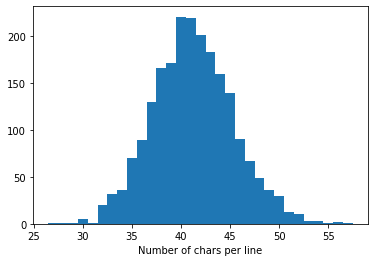

In [15]:
proc_lines = [' '.join(l) for l in basic_processed_seqs]
char_len = [len(l) for l in proc_lines]
n, bins, _ = plt.hist(char_len, bins=[i-0.5 for i in range(min(char_len), max(char_len)+2)])
plt.xlabel('Number of chars per line')
plt.show()

### 4. Adv Pre-processing (char-based) for Adv RNN

Let's do a more careful char-based data cleaning. Here, don't use sequences across poems. Only use 40-char sequences within individual poems. And we keep all punctuations except for newline char. 

In [16]:
# get all useful chars in each line in both files
raw_seqs = []
for infile in ['raw_data/shakespeare.txt','raw_data/spenser.txt']:
    with open(infile) as f:
        for line in f.readlines():
            # tokenize each seq, split punctuations, keep \n char
            words = line.lower().split()

            # remove empty lists
            if words:
                raw_seqs.append(words)

# gather seqs of words within poems into dictionaries indexed by numbers
all_poems = {}
counter = 0
for seq in raw_seqs:
    if len(seq) == 1:
        counter += 1
        all_poems[counter] = []
    else:
        all_poems[counter].append(seq)

# join words into lines for each poem
for poem in all_poems:
    all_poems[poem] = [' '.join(line) for line in all_poems[poem]]

# join poem lines into a long string of raw text for RNN training sequencing
proc_text = [' '.join(all_poems[i]) for i in all_poems]

Store all of the 40-char sequences.

In [17]:
max_len = 40
step = 1
adv_char_seqs = []
for pt in proc_text:
    for i in range(0, len(pt)-max_len, step):
        adv_char_seqs.append(pt[i:i+max_len+1])

print('Total number of sequences: {}'.format(len(adv_char_seqs)))

Total number of sequences: 137247


Save the 'chars to vectors' and 'vectors to chars' mappings.

In [18]:
adv_chars = sorted(list(set(''.join(proc_text))))
adv_char2vec = dict((c, i) for i, c in enumerate(adv_chars))
adv_vec2char = dict((i, c) for i, c in enumerate(adv_chars))
pickle.dump(adv_char2vec, open("processed_data/adv_char2vec.p", "wb"))
pickle.dump(adv_vec2char, open("processed_data/adv_vec2char.p", "wb"))
print('Total number of unique chars: {}'.format(len(adv_char2vec)))
print('All unique chars: ')
print(adv_chars)

Total number of unique chars: 38
All unique chars: 
[' ', '!', '&', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Save the processed char-based sequence vectors.

In [19]:
adv_char_seqs_vec = []
for char_s in adv_char_seqs:
    adv_char_seqs_vec.append([adv_char2vec[c] for c in char_s])
pickle.dump(adv_char_seqs_vec, open("processed_data/adv_char_seqs_vec.p", "wb"))